Análise do dia 02/04 através do modelo LDA.

In [1]:
# Importar bibliotecas

# gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from ast import literal_eval

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

# sklearn
from sklearn.feature_extraction.text import CountVectorizer

#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Preparação dos dados

In [2]:
# import dos dados

df = pd.read_csv('0204_preprocessado.csv')

In [3]:
# função para reverter os tokens processados em lista de tuples

def strip_characters(text):
    t = re.sub(r'\(|\)|:|,|;|\.|’|”|“|\?|%|>|<|\[|\]', '', text)
    t = re.sub(r'/', ' ', t)
    t = t.replace("'",'')
    return t

In [4]:
# aplica função em todos os tokens

df['token3'] = df['token3'].apply(lambda x: strip_characters(x))
df['token3'] = df['token3'].apply(lambda x: str(x).split(' '))

In [5]:
texto = list(df.token3)

# Modelagem

In [6]:
# Criar dicionário

id2word = corpora.Dictionary(texto)

In [7]:
# Criar o Corpus: A Frequência das palavras nos documentos

corpus = [id2word.doc2bow(text) for text in texto]

In [8]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [9]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=30, step=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [10:18<00:00, 44.16s/it]


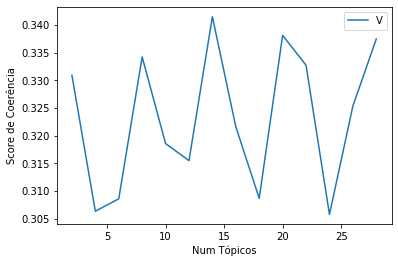

In [10]:
# Mostrando visualmente a quantidade de tópicos

limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [11]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico

for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.3309
A quantidade de tópicos = 4  tem um valor de coerência de  0.3064
A quantidade de tópicos = 6  tem um valor de coerência de  0.3086
A quantidade de tópicos = 8  tem um valor de coerência de  0.3342
A quantidade de tópicos = 10  tem um valor de coerência de  0.3186
A quantidade de tópicos = 12  tem um valor de coerência de  0.3155
A quantidade de tópicos = 14  tem um valor de coerência de  0.3415
A quantidade de tópicos = 16  tem um valor de coerência de  0.3216
A quantidade de tópicos = 18  tem um valor de coerência de  0.3087
A quantidade de tópicos = 20  tem um valor de coerência de  0.3381
A quantidade de tópicos = 22  tem um valor de coerência de  0.3327
A quantidade de tópicos = 24  tem um valor de coerência de  0.3058
A quantidade de tópicos = 26  tem um valor de coerência de  0.3254
A quantidade de tópicos = 28  tem um valor de coerência de  0.3375


Aqui conseguimos determinar a melhor quantidade de tópicos a serem analisados, que é 8 tópicos

In [18]:
# Vamos agora construir de fato o modelo LDA

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=3, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)

In [19]:
# Computar a perplexidade do modelo (quanto menor, melhor)

print('\nPerplexidade: ', lda_model.log_perplexity(corpus))


Perplexidade:  -7.072488378676285


In [20]:
# Computar o Score de Coerência

coherence_model_lda = CoherenceModel(model=lda_model, texts=texto, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)


Score de Coerência:  0.3748732180304053


In [21]:
# Visualização dos tópicos em clusters

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.144495 -0.351166       1        1  35.823444
1     -0.239685  0.297585       2        1  32.244640
0      0.384180  0.053581       3        1  31.931915, topic_info=           Term          Freq         Total Category  logprob  loglift
0     bolsonaro  19433.000000  19433.000000  Default  30.0000  30.0000
18   presidente  18282.000000  18282.000000  Default  29.0000  29.0000
16     pandemia  12058.000000  12058.000000  Default  28.0000  28.0000
31               11192.000000  11192.000000  Default  27.0000  27.0000
21         casa   7796.000000   7796.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
104       pouco   1244.096069   1244.732666   Topic3  -5.2335   1.1411
246        amor   1188.784424   1189.425903   Topic3  -5.2789   1.1410
650      morrer   1176.925781   1177.562744   Topic3  -5.2890   1.1410
339      grande   1195.229126   1195.885132   Topic3  -5.2735   1.1410
179      tambem   2516.557373   2604.747559   Topic3  -4.5290   1.1071

[126 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
31        1  0.999933         
25        2  0.999867   acabar
32        1  0.249453    agora
32        2  0.731192    agora
32        3  0.019331    agora
...     ...       ...      ...
93        3  0.999441      vez
86        2  0.999792     vida
149       3  0.999684    video
453       2  0.999850   voltar
44        3  0.999259  vontade

[99 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [22]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=4, step=2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:49<00:00, 49.75s/it]


In [24]:
# Escolhe o modelo

optimal_model = model_list[0]
optimal_model.print_topics(num_topics = 3, num_words = 20)

[(0,
  '0.027*"pandemia" + 0.026*"casa" + 0.016*"gente" + 0.011*"mundo" + 0.010*"deus" + 0.010*"ir" + 0.009*"agora" + 0.008*"quando" + 0.008*"nunca" + 0.008*"nem" + 0.008*"menos" + 0.007*"mae" + 0.007*"logo" + 0.007*"coisa" + 0.007*"cabelo" + 0.007*"nada" + 0.007*"meio" + 0.006*"depois" + 0.006*"muito" + 0.006*"tempo"'),
 (1,
  '0.079*"bolsonaro" + 0.052*"presidente" + 0.051*"" + 0.015*"povo" + 0.014*"contra" + 0.012*"governo" + 0.012*"agora" + 0.009*"pandemia" + 0.009*"lula" + 0.009*"brasil" + 0.009*"doria" + 0.008*"nem" + 0.005*"tambem" + 0.005*"momento" + 0.005*"sim" + 0.005*"porque" + 0.004*"jair" + 0.004*"dinheiro" + 0.004*"falar" + 0.004*"merda"'),
 (2,
  '0.026*"acabar" + 0.024*"presidente" + 0.022*"quando" + 0.019*"brasil" + 0.017*"saude" + 0.013*"muito" + 0.013*"depois" + 0.011*"pandemia" + 0.010*"sair" + 0.010*"novo" + 0.008*"gente" + 0.008*"primeiro" + 0.007*"video" + 0.007*"caso" + 0.007*"nem" + 0.006*"nada" + 0.006*"mil" + 0.006*"vida" + 0.006*"passar" + 0.006*"coisa"')]

In [25]:
# Encontrar qual o principal tópico em cada tweet

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texto):
    # Output
    sent_topics_df = pd.DataFrame()

    # Seleciona o principal tópico de cada tweet
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => mostra o principal tópico
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']

    # Inclui o texto original no final do DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [26]:
# roda a função de calcular os principais tópicos de cada tweet

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texto)

In [27]:
# Formata o DataFrame

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']

In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]

# Show
sent_topics_sorteddf_mallet

,Topico,Topico_Perc_Contrib,Palavras_Chave,Tweet
0,0.0,0.9604,"pandemia, casa, gente, mundo, deus, ir, agora,...","[irma, irmao, tempo, casa, embora, comigo, sur..."
1,1.0,0.9663,"bolsonaro, presidente, , povo, contra, governo...","[desflopando, exposed, daddy, volta, marcela, ..."
2,2.0,0.9546,"acabar, presidente, quando, brasil, saude, mui...","[marco, caso, oms, quase, brasil, depois, bom,..."


In [29]:
# Numero de tweets por topico

topic_counts = df_topic_sents_keywords['Principal_Topico'].value_counts()

# Porcentagem de tweets por tópico
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Número do tópico e suas palavras chave
topic_num_keywords = df_topic_sents_keywords[['Principal_Topico', 'Palavras_Chave']]

# Concatena as colunas
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomeia as colunas
df_dominant_topics.columns = ['Principal_Topico', 'Palavras_Chave', 'Qtd_Tweets', 'Perc_Tweets']

# Mostra o DataFrame
df_dominant_topics

,Principal_Topico,Palavras_Chave,Qtd_Tweets,Perc_Tweets
0.0,1.0,"bolsonaro, presidente, , povo, contra, governo...",64143.0,0.3740
1.0,0.0,"pandemia, casa, gente, mundo, deus, ir, agora,...",59225.0,0.3453
2.0,0.0,"pandemia, casa, gente, mundo, deus, ir, agora,...",48158.0,0.2808
3.0,1.0,"bolsonaro, presidente, , povo, contra, governo...",NaN,NaN
4.0,0.0,"pandemia, casa, gente, mundo, deus, ir, agora,...",NaN,NaN
...,...,...,...,...
171521.0,1.0,"bolsonaro, presidente, , povo, contra, governo...",NaN,NaN
171522.0,1.0,"bolsonaro, presidente, , povo, contra, governo...",NaN,NaN
171523.0,2.0,"acabar, presidente, quando, brasil, saude, mui...",NaN,NaN
171524.0,1.0,"bolsonaro, presidente, , povo, contra, governo...",NaN,NaN


In [30]:
# Criando stopwords em português utilizando a biblioteca nltk
import pt_core_news_sm
nlp = pt_core_news_sm.load()
pt_stopwords = sorted([token.text for token in nlp.vocab if token.is_stop])
list_exclude = ['obrigado', 'bom', 'mal', 'nenhuma', 'maior',
             'bem', 'não', 'máximo', 'boa', 'mais',
               'bastante', 'certamente', 'certeza', 'contra',
                'quarentena', 'coronavírus', 'presidente', 'impeachment', 'demitido', 'demitida']
for word in list_exclude:
    nlp.vocab[word].is_stop = False
list_include = set(['o', 'a', 'tá', 'ta', 'ser', 'pro', 'to', 'tô', 'vc', 'você', 'voce', 'pra',
                    'pq', 'é', 'vou', 'que','tão', 'gt', 'de', 'da', 'do', 'em', 'uma', 'lá',
                    'já', 'no', 'para', 'na', 'com', 'um', 'minha', 'se', 'isso', 'por', 'vou',
                    'os', 'isso', 'como', 'mesmo', 'tenho', 'aqui', 'ele', 'ela', 'quem', 'fazer',
                    'eu', 'só', 'ai', 'mais', 'só', 'querer', 'https', 'ter', 'estar', 'ficar',
                    'dos', 'das', 'vcs', 'tem', 'as', 'mas','ao'
                    'tava', 'nao', 'sao', 'ja', 'so', 'nossa',
                    'nosso', 'estao', 'tco', 'me', 'dia', 'te', 'ver', 'sera', 'porra', 'fez', 'ne',
                    'kkk','kkkkkk', 'puta', 'kkkkkkkk', 'hj', 'afff', 'gbr', 'meu', 'cara', 'guri', 'cmg',
                    'ctg', 'agr', 'pqp', 'vdd', 'eh', 'va', 'obg',
                    'corona','virus','coronavirus','covid','covid19','19'
                   'nem', 'numa', 'num', 'nuns', 'ces', 'voces', 'oce', 'oces', 'kkkk', 'vao', 'via',
                    'hj', 'hoje', 'tudo', 'todo', 'toda',
                    'vir', 'bem','ao','sem','ou','vai', 'dizer', 'entao', 'dizer', 'entao',
                    'tao', 'tu', 'mim', 'mano', 'oq', 'pos', 'dm', 'dps',
                    'coronavirusoutbreak', 'coronavirusPandemic', 'dar', 'vairus',
                    'ainda', 'assim']
                  )
for w in list_include:
    nlp.vocab[w].is_stop = True
stop_words = sorted([token.text for token in nlp.vocab if token.is_stop])

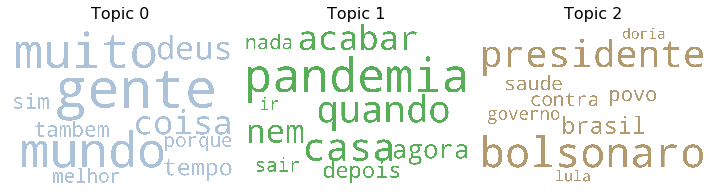

In [33]:
# Cria wordclouds

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [34]:
sent_topics_sorteddf_mallet.to_excel('keywords_0402.xlsx')